In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR
from utils import CustomDataset, train, compute_weights_by_y_train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### tfidf as input

In [2]:
if torch.cuda.is_available(): # in my case it means running in colab
    from google.colab import drive
    drive.mount('/content/drive')
    from pathlib import Path
    sources_path = Path("/content/drive/MyDrive")
    X_train = np.load(str(sources_path / 'Data/doc2idxs_X_train.npy'))
    y_train = np.load(str(sources_path / 'Data/y_train.npy'))
    X_test = np.load(str(sources_path / 'Data/doc2idxs_X_test.npy'))
    y_test = np.load(str(sources_path / 'Data/y_test.npy'))

    saving_path=str(sources_path / 'Trained_models/NN_doc2idxs.pth')
else:
    X_train = np.load('Data/unbalanced/tfidf_X_train.npy')
    y_train = np.load('Data/unbalanced/y_train.npy')
    X_test = np.load('Data/unbalanced/tfidf_X_test.npy')
    y_test = np.load('Data/unbalanced/y_test.npy')

    saving_path='Trained_models/NN_tfidf.pth'

train_df = CustomDataset(X_train, y_train)
test_df = CustomDataset(X_test, y_test)

weights=compute_weights_by_y_train(y_train)

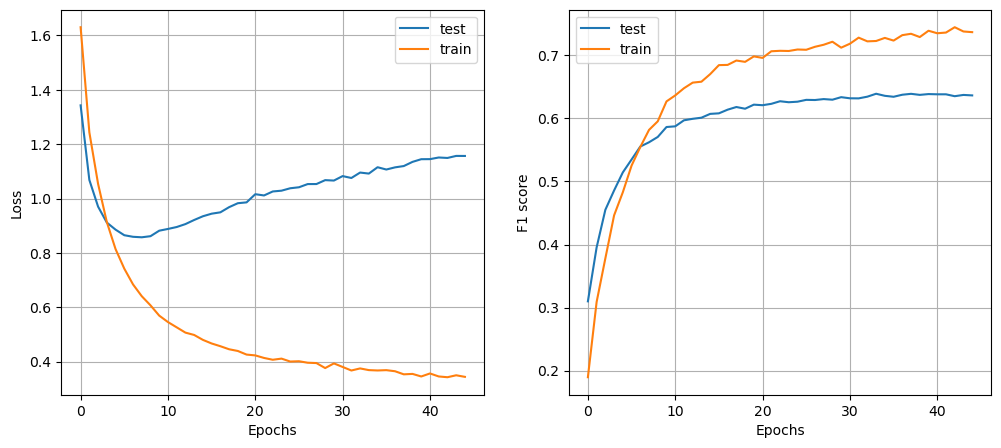

100%|██████████| 45/45 [02:26<00:00,  3.24s/it]


In [4]:
in_features = X_train.shape[1]
out_features = 5
hidden_size = 512

net = nn.Sequential(nn.BatchNorm1d(in_features),
                    nn.Linear(in_features, hidden_size), nn.BatchNorm1d(hidden_size), nn.ReLU(), nn.Dropout(0.5),
                    nn.Linear(hidden_size, out_features), nn.LogSoftmax(dim=1)).to(device)

optimizer = Adam(net.parameters(), lr=1e-4)
train(net,
      optimizer=optimizer,
      criterion=nn.NLLLoss(weight=weights),
      train_loader=DataLoader(train_df, batch_size=256, shuffle=True),
      test_loader=DataLoader(test_df, batch_size=256, shuffle=False),
      epochs=45,
      saving_path=saving_path,
      scheduler=StepLR(optimizer, step_size=1, gamma=0.99))

In [5]:
with torch.no_grad():
    y_pred = torch.argmax(net(torch.from_numpy(X_test).float().to(device)), dim=1).cpu().numpy() - 2
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.48      0.74      0.58       473
          -1       0.71      0.72      0.71      2746
           0       0.85      0.72      0.78      4174
           1       0.50      0.74      0.59       522
           2       0.45      0.80      0.57       105

    accuracy                           0.72      8020
   macro avg       0.60      0.74      0.65      8020
weighted avg       0.75      0.72      0.73      8020



### Doc2vec as input

In [9]:
if torch.cuda.is_available(): # in my case it means running in colab
    from google.colab import drive
    drive.mount('/content/drive')
    from pathlib import Path
    sources_path = Path("/content/drive/MyDrive")
    X_train = np.load(str(sources_path / 'Data/doc2matrix_X_train.npy'))
    y_train = np.load(str(sources_path / 'Data/y_train.npy'))
    X_test = np.load(str(sources_path / 'Data/doc2matrix_X_test.npy'))
    y_test = np.load(str(sources_path / 'Data/y_test.npy'))

    saving_path=str(sources_path / 'Trained_models/NN_doc2matrix.pth')
else:
    X_train = np.load('Data/unbalanced/doc2vec_X_train.npy')
    y_train = np.load('Data/unbalanced/y_train.npy')
    X_test = np.load('Data/unbalanced/doc2vec_X_test.npy')
    y_test = np.load('Data/unbalanced/y_test.npy')

    saving_path='Trained_models/NN_doc2vec.pth'

train_df = CustomDataset(X_train, y_train)
test_df = CustomDataset(X_test, y_test)

weight=compute_weights_by_y_train(y_train)
print(weight)

tensor([ 9.1945,  1.5061,  1.0000,  8.0872, 38.9480])


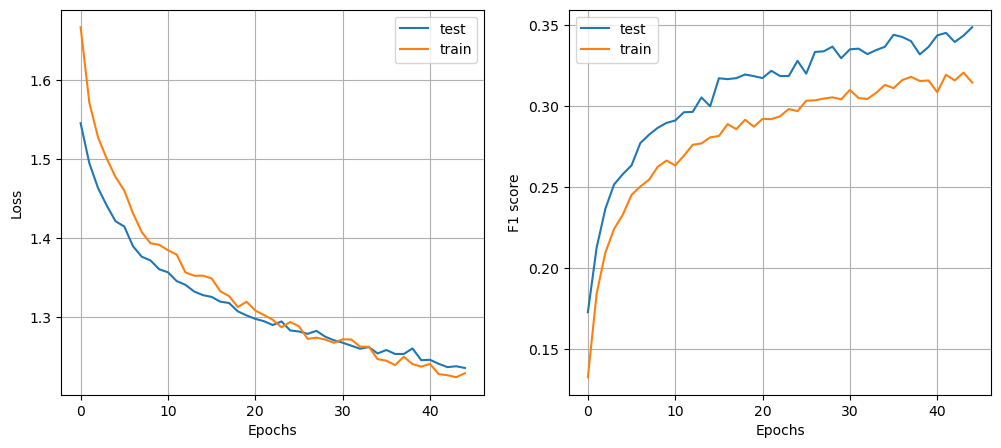

100%|██████████| 45/45 [00:27<00:00,  1.61it/s]


In [8]:
in_features = X_train.shape[1]
out_features = 5
hidden_size = 128

net = nn.Sequential(nn.BatchNorm1d(in_features),
                    nn.Linear(in_features, hidden_size), nn.BatchNorm1d(hidden_size), nn.ReLU(), nn.Dropout(0.5),
                    nn.Linear(hidden_size, out_features), nn.LogSoftmax(dim=1)).to(device)

optimizer = Adam(net.parameters(), lr=1e-4)
train(net,
      optimizer=optimizer,
      criterion=nn.NLLLoss(weight=weight),
      train_loader=DataLoader(train_df, batch_size=256, shuffle=True),
      test_loader=DataLoader(test_df, batch_size=256, shuffle=False),
      epochs=45,
      saving_path=saving_path,
      scheduler=StepLR(optimizer, step_size=1, gamma=0.99))

In [7]:
with torch.no_grad():
    y_pred = torch.argmax(net(torch.from_numpy(X_test).float().to(device)), dim=1).cpu().numpy() - 2
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -2       0.44      0.74      0.55       473
          -1       0.68      0.69      0.69      2746
           0       0.84      0.68      0.75      4174
           1       0.46      0.77      0.57       522
           2       0.43      0.81      0.56       105

    accuracy                           0.69      8020
   macro avg       0.57      0.74      0.63      8020
weighted avg       0.73      0.69      0.70      8020

